In [59]:
import scipy.io as sio
import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, ReLU, BatchNormalization, Flatten, Reshape, Conv2D

from tensorflow.keras.layers import UpSampling2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from numpy import zeros, reshape, mean, array, squeeze, expand_dims, abs, angle, argmax, arange, floor, ceil, ravel
from numpy import asarray
from numpy.random import normal
from numpy.linalg import norm
from numpy import concatenate
from numpy.random import choice
import os
import datetime
from pickle import dump, load
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from neural_net_model import neural_net_model
import shap

In [60]:
train_SNR = 10
num_epochs = 7
dataset_size = 1_008_000
path_to_data = f"{os.getcwd()}/Datasets_v2/Datafiles/Sim_data/"

norm_tx, norm_rx = 0, 0

filename_train = f'{path_to_data}pucch_fading_{train_SNR}dB_{int(dataset_size/1000)}k_norm_tx_{norm_tx}_norm_rx_{norm_rx}.mat'
data = sio.loadmat(filename_train)
X = data['X']
Y = data['Y']

In [61]:
Z = to_categorical(Y)

# Split datasets into training and testing
num_train = int(0.75 * dataset_size)
num_test = int(dataset_size - num_train)

x_train, x_test = X[0:num_train, :], X[num_train:, :]
y_train, y_test = Y[0:num_train, :], Y[num_train:, :]
z_train, z_test = Z[0:num_train, :], Z[num_train:, :]

print(x_train.shape)

(756000, 24)


In [62]:
model = neural_net_model()
model.summary()

optimizer = SGD(learning_rate=1e-3, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, z_train, epochs=num_epochs, batch_size=512, validation_split=0.3, verbose=2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 24)]              0         
_________________________________________________________________
fc_0 (Dense)                 (None, 128)               3200      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 12)                1548      
Total params: 21,260
Trainable params: 21,260
Non-trainable params: 0
_______________________________________________________

2022-07-07 08:00:50.156886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-07 08:00:55.617159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1034/1034 - 7s - loss: 2.2173 - accuracy: 0.2697 - val_loss: 1.6465 - val_accuracy: 0.9078
Epoch 2/7
1034/1034 - 7s - loss: 1.5196 - accuracy: 0.5894 - val_loss: 0.8527 - val_accuracy: 0.9439
Epoch 3/7
1034/1034 - 7s - loss: 1.0277 - accuracy: 0.7315 - val_loss: 0.5107 - val_accuracy: 0.9522
Epoch 4/7
1034/1034 - 7s - loss: 0.7706 - accuracy: 0.7960 - val_loss: 0.3690 - val_accuracy: 0.9554
Epoch 5/7
1034/1034 - 7s - loss: 0.6355 - accuracy: 0.8282 - val_loss: 0.2989 - val_accuracy: 0.9572
Epoch 6/7
1034/1034 - 7s - loss: 0.5506 - accuracy: 0.8486 - val_loss: 0.2581 - val_accuracy: 0.9582
Epoch 7/7
1034/1034 - 7s - loss: 0.4962 - accuracy: 0.8606 - val_loss: 0.2321 - val_accuracy: 0.9591


## Add Explaninability to the model

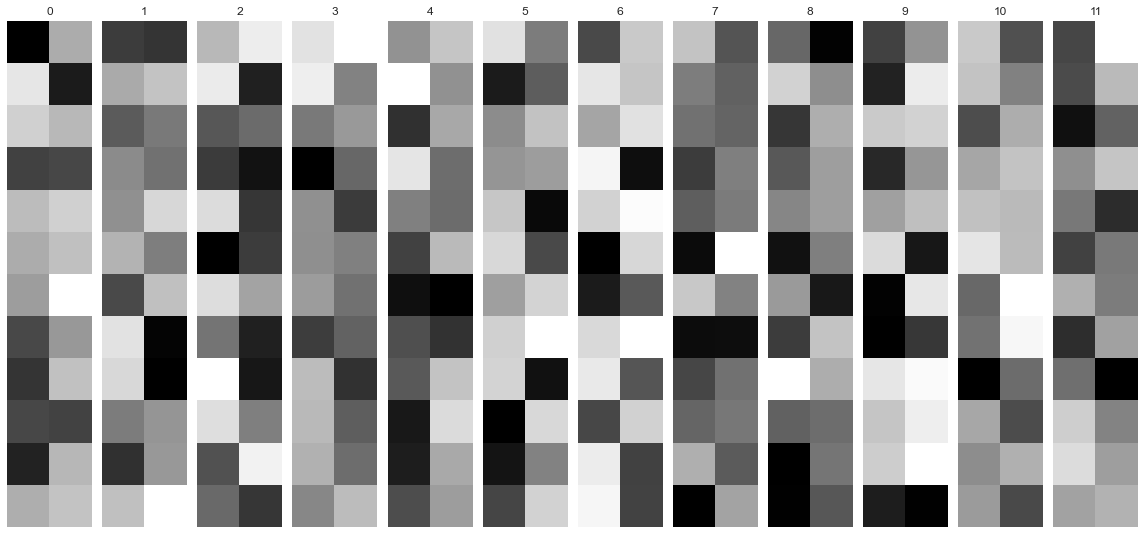

In [63]:
classes = list(range(12))

# Save one instance of each class
pucch_train_instances = dict()
for i, j in enumerate(y_train):
    if len(pucch_train_instances) == 12:
        break
        
    if j[0] not in pucch_train_instances.keys():
        pucch_train_instances[j[0]] = x_train[i, :].reshape((12, 2))

# Plot
fig, axes = plt.subplots(1, 12, figsize=(16, 15))
axes = axes.flatten()

# # Plot an empty canvas
# ax = axes[0]
# dummy_array = array([[[0, 0, 0, 0]]], dtype='uint8')
# ax.set_title("reference")
# ax.set_axis_off()
# ax.imshow(dummy_array, interpolation='nearest')


# Plot an image for every category
for k,v in pucch_instances.items():
    ax = axes[k]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{classes[k]}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [64]:
# Take a random sample of 5000 training instances
background = x_train[choice(x_train.shape[0], 5000, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [97]:
# Save an example of each class from the test set
pucch_test_instances = dict()
for i, j in enumerate(y_test):
    if len(pucch_test_instances) == 12:
        break
    if j[0] not in pucch_test_instances.keys():
        pucch_test_instances[j[0]] = x_test[i, :]

# Convert to list preserving order of classes
x_test_each_class = [pucch_test_instances[i] for i in sorted(pucch_test_instances)]

# Convert to tensor
x_test_each_class = asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")
print(type(x_test_each_class))

x_test_each_class tensor has shape: (12, 24)
<class 'numpy.ndarray'>


In [107]:
x_test_each_class_mat = zeros((12, 12, 2), dtype=float)
for i in range(12):
    x_test_each_class_mat[i, :, :] = x_test_each_class[i, :].reshape((12, 2))
print(x_test_each_class_mat.shape)

(12, 12, 2)


In [108]:
# Compute predictions
predictions = model.predict(x_test_each_class)

# Apply argmax to get predicted class
argmax(predictions, axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [113]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)
# print(shap_values[0].shape) 

shap_values_mat = list()
for i in range(12): # list
    for j in range(12):
        # print(shap_values[i].shape)
        shap_values_mat.append(shap_values[i][j, :].reshape((12, 2)))
print(shap_values_mat[0].shape)

(12, 2)


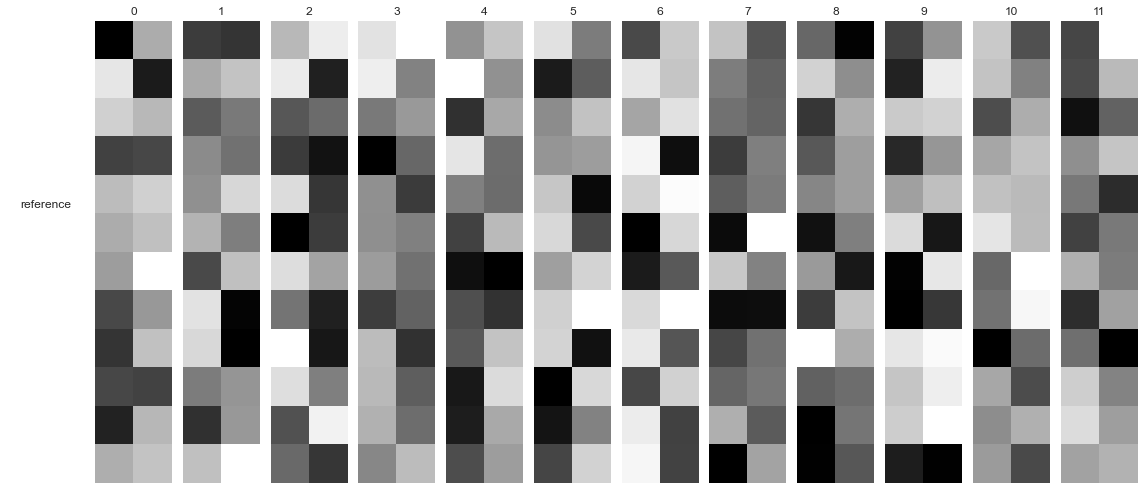


<class 'list'> <class 'list'>


TypeError: bad operand type for unary -: 'list'

In [105]:
# Plot
fig, axes = plt.subplots(1, 13, figsize=(16, 15))
axes = axes.flatten()

# Plot an empty canvas
ax = axes[0]
dummy_array = array([[[0, 0, 0, 0]]], dtype='uint8')
ax.set_title("reference")
ax.set_axis_off()
ax.imshow(dummy_array, interpolation='nearest')


# Plot an image for every category
for k,v in pucch_train_instances.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{classes[k]}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()


# Print an empty line to separate the two plots
print()

print(type(shap_values_mat), type(x_test_each_class_mat))
# Plot shap values
shap.image_plot(shap_values_mat, -x_test_each_class_mat)

In [ ]:
# create save folder if it doesn't exist
save_folder = './Weights'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


# save weights
weights_save_path = os.path.join(save_folder, 'weights_128_12_class.h5')
model.save_weights(weights_save_path)

In [ ]:
# plt.rcParams['axes.edgecolor'] = 'black'
# plt.figure()
# markers = list(arange(0, num_epochs, 50))
# markers[-1] = markers[-1] - 1
# plt.plot(history.history['loss'], 's-r', label='Training', markevery=markers)
# plt.plot(history.history['val_loss'], '^-b', label='Validation', markevery=markers)
# plt.title(f'Model Loss, SNR = {train_SNR} dB', fontsize=16, fontweight="bold")
# plt.ylabel('Categorical Cross Entropy Loss', fontsize=16, fontweight="bold")
# plt.xlabel('Training Epoch', fontsize=16, fontweight="bold")
# plt.grid(True)
# plt.legend(loc='upper right', prop=dict(weight='bold'))
# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')

# plt.savefig(f'./Plots/Loss_{train_SNR}_dB_single_train_multiple_test.png', dpi=400)

# acc_perc = [100*a for a in history.history['accuracy']]
# val_acc_perc = [100*a for a in history.history['val_accuracy']]
# plt.figure()
# plt.plot(acc_perc, 's-r', label='Training', markevery=markers)
# plt.plot(val_acc_perc, '^-b', label='Validation', markevery=markers)
# plt.title(f'Model Accuracy, SNR = {train_SNR} dB', fontsize=16, fontweight="bold")
# plt.ylabel('Accuracy (%)', fontsize=16, fontweight="bold")
# plt.xlabel('Training Epoch', fontsize=16, fontweight="bold")
# plt.grid(True)
# plt.legend(loc='lower right', prop=dict(weight='bold'))
# plt.xticks(fontsize=12, fontweight='bold')
# # plt.yticks(arange(floor(min(acc_perc)), floor(max(val_acc_perc))+1, 2), fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.savefig(f'./Plots/Accuracy_{train_SNR}_dB_single_train_multiple_test.png', dpi=400)